**Корректность проверена на Python 3.7:**
+ pandas 0.23.0
+ numpy 1.14.5
+ scipy 1.1.0
+ statsmodels 0.9.0

# Линейная регрессия

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import statsmodels
import scipy as sc
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
import matplotlib.pyplot as plt

In [3]:
print(np.__version__)
print(pd.__version__)
print(sc.__version__)
print(statsmodels.__version__)

1.18.2
1.0.3
1.4.1
0.10.1


In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Постановка

По 1260 опрошенным имеются следующие данные:

* заработная плата за час работы, $;
* опыт работы, лет;
* образование, лет;
* внешняя привлекательность, в баллах от 1 до 5;
* бинарные признаки: пол, семейное положение, состояние здоровья (хорошее/плохое), членство в профсоюзе, цвет кожи (белый/чёрный), занятость в сфере обслуживания (да/нет).

Требуется оценить влияние внешней привлекательности на уровень заработка с учётом всех остальных факторов.

Hamermesh D.S., Biddle J.E. (1994) Beauty and the Labor Market, American Economic Review, 84, 1174–1194.

Данные:

In [5]:
raw = pd.read_csv("beauty.csv", sep=";", index_col=False) 
raw.head()

,wage,exper,union,goodhlth,black,female,married,service,educ,looks
0,5.73,30,0,1,0,1,1,1,14,4
1,4.28,28,0,1,0,1,1,0,12,3
2,7.96,35,0,1,0,1,0,0,10,4
3,11.57,38,0,1,0,0,1,1,16,3
4,11.42,27,0,1,0,0,1,0,16,3


Посмотрим на матрицу диаграмм рассеяния по количественным признакам:

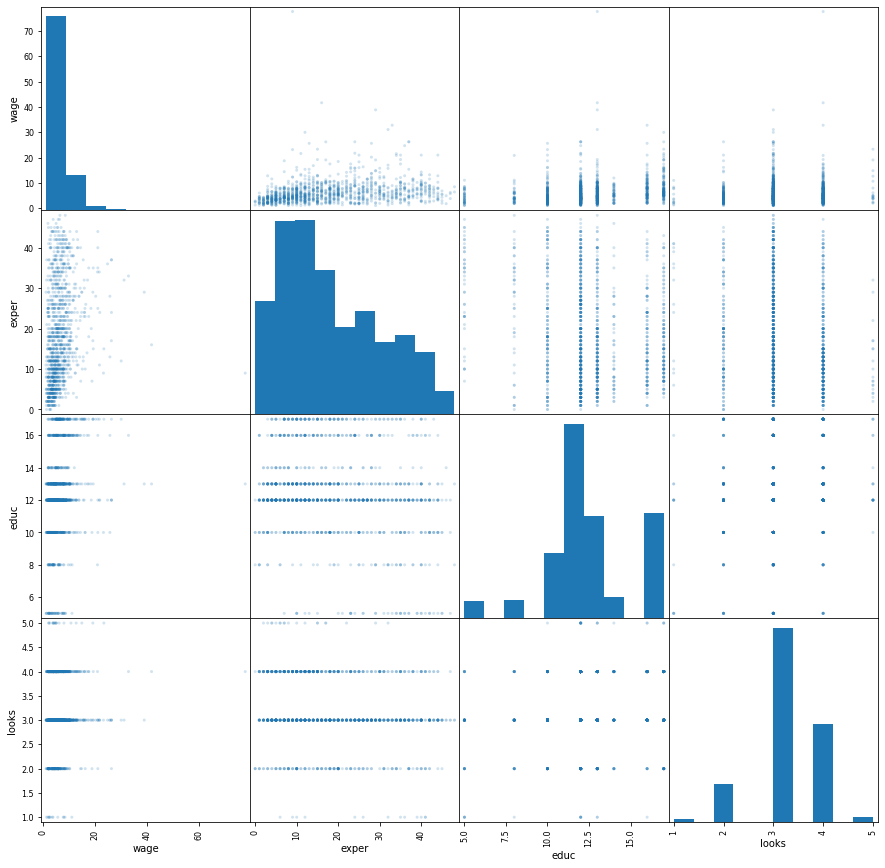

In [6]:
pd.plotting.scatter_matrix(raw[['wage', 'exper', 'educ', 'looks']], alpha=0.2, 
                                 figsize=(15, 15), diagonal='hist')
pylab.show()

Оценим сбалансированность выборки по категориальным признакам:

In [7]:
print(raw.union.value_counts())
print(raw.goodhlth.value_counts())
print(raw.black.value_counts())
print(raw.female.value_counts())
print(raw.married.value_counts())
print(raw.service.value_counts())

0    917
1    343
Name: union, dtype: int64
1    1176
0      84
Name: goodhlth, dtype: int64
0    1167
1      93
Name: black, dtype: int64
0    824
1    436
Name: female, dtype: int64
1    871
0    389
Name: married, dtype: int64
0    915
1    345
Name: service, dtype: int64


У каждого признака все значения встречаются достаточно много раз, так что всё в порядке.

## Предобработка

In [8]:
data = raw

Посмотрим на распределение целевого признака — уровня заработной платы: 

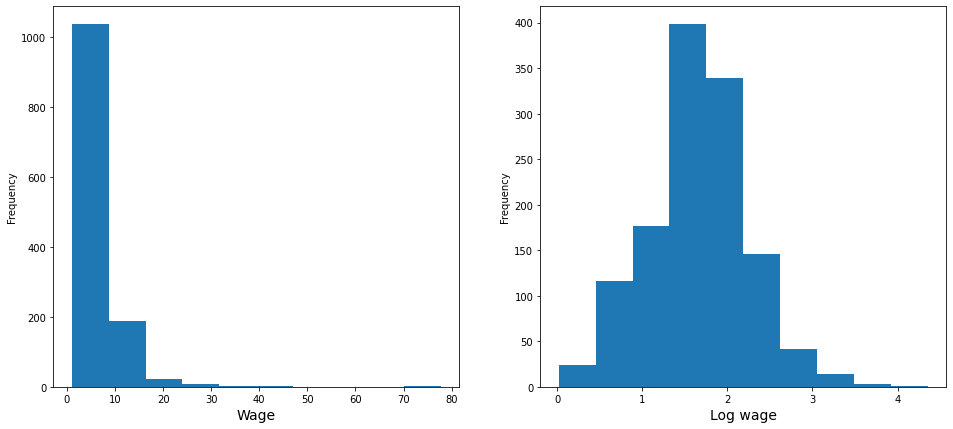

In [9]:
plt.figure(figsize(16,7))
plt.subplot(121)
data['wage'].plot.hist()
plt.xlabel('Wage', fontsize=14)

plt.subplot(122)
np.log(data['wage']).plot.hist()
plt.xlabel('Log wage', fontsize=14)
pylab.show()

Один человек в выборке получает 77.72\$ в час, остальные — меньше 45\$; удалим этого человека, чтобы регрессия на него не перенастроилась.

In [10]:
data = data[data['wage'] < 77]

Посмотрим на распределение оценок привлекательности: 

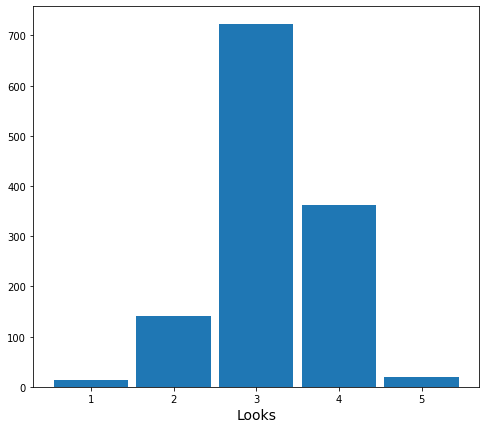

In [11]:
plt.figure(figsize(8,7))
data.groupby('looks')['looks'].agg(lambda x: len(x)).plot(kind='bar', width=0.9)
plt.xticks(rotation=0)
plt.xlabel('Looks', fontsize=14)
pylab.show()

В группах looks=1 и looks=5 слишком мало наблюдений. Превратим признак looks в категориальный и закодируем с помощью фиктивных переменных:

In [12]:
data['belowavg'] = data['looks'].apply(lambda x : 1 if x < 3 else 0)
data['aboveavg'] = data['looks'].apply(lambda x : 1 if x > 3 else 0)
data.drop('looks', axis=1, inplace=True)

Данные теперь:

In [13]:
data.head()

,wage,exper,union,goodhlth,black,female,married,service,educ,belowavg,aboveavg
0,5.73,30,0,1,0,1,1,1,14,0,1
1,4.28,28,0,1,0,1,1,0,12,0,0
2,7.96,35,0,1,0,1,0,0,10,0,1
3,11.57,38,0,1,0,0,1,1,16,0,0
4,11.42,27,0,1,0,0,1,0,16,0,0


## Построение модели

### Простейшая модель

Построим линейную модель по всем признакам.

In [15]:
m1 = smf.ols('wage ~ exper + union + goodhlth + black + female + married +'\
                    'service + educ + belowavg + aboveavg', 
             data=data)
fitted = m1.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     44.31
Date:                Thu, 12 Aug 2021   Prob (F-statistic):           1.42e-75
Time:                        21:45:32   Log-Likelihood:                -3402.9
No. Observations:                1259   AIC:                             6828.
Df Residuals:                    1248   BIC:                             6884.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5898      0.743     -0.793      0.4

Посмотрим на распределение остатков:

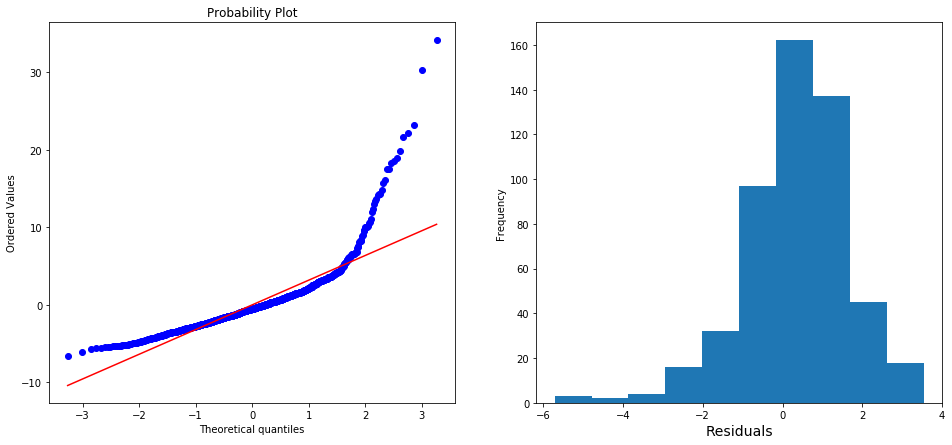

In [15]:
plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

Оно скошенное, как и исходный признак. В таких ситуациях часто помогает перейти от регрессии исходного признака к регрессии его логарифма.

### Логарифмируем отклик

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     77.63
Date:                Wed, 03 Jul 2019   Prob (F-statistic):          1.18e-123
Time:                        19:35:25   Log-Likelihood:                -816.90
No. Observations:                1259   AIC:                             1656.
Df Residuals:                    1248   BIC:                             1712.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4515      0.095      4.737      0.0

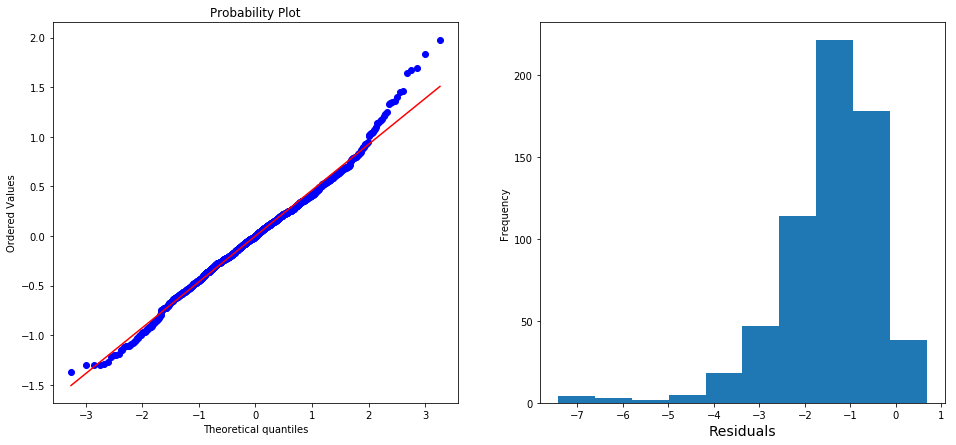

In [16]:
m2 = smf.ols('np.log(wage) ~ exper + union + goodhlth + black + female + married +'\
                            'service + educ + belowavg + aboveavg', data=data)
fitted = m2.fit()
print(fitted.summary())

plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

Теперь стало лучше. Посмотрим теперь на зависимость остатков от непрерывных признаков:

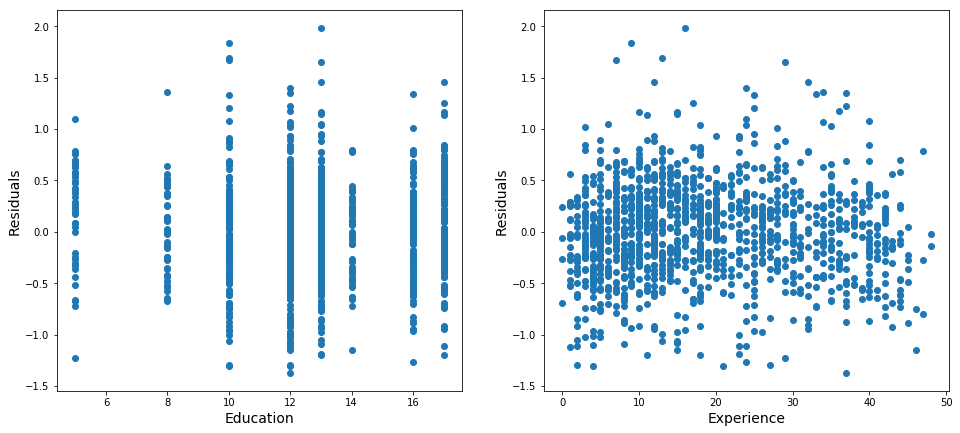

In [17]:
plt.figure(figsize(16,7))
plt.subplot(121)
scatter(data['educ'],fitted.resid)
plt.xlabel('Education', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(122)
scatter(data['exper'],fitted.resid)
plt.xlabel('Experience', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
pylab.show()

На втором графике видна квадратичная зависимость остатков от опыта работы. Попробуем добавить к признакам квадрат опыта работы, чтобы учесть этот эффект.

### Добавляем квадрат опыта работы

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     76.46
Date:                Wed, 03 Jul 2019   Prob (F-statistic):          3.19e-131
Time:                        19:35:27   Log-Likelihood:                -796.86
No. Observations:                1259   AIC:                             1618.
Df Residuals:                    1247   BIC:                             1679.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3424      0

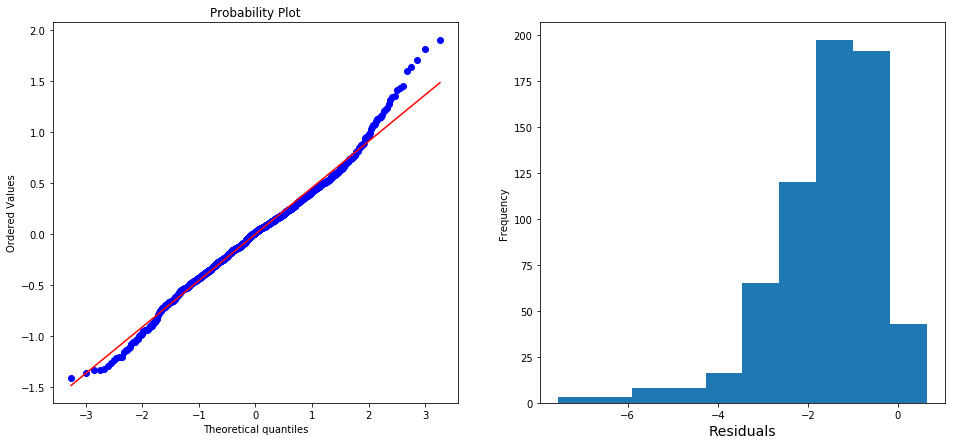

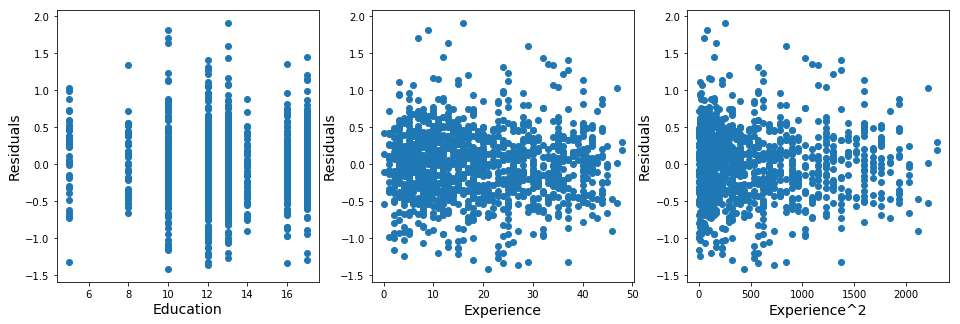

In [18]:
m3 = smf.ols('np.log(wage) ~ exper + np.power(exper,2) + union + goodhlth + black + female +'\
                            'married + service + educ + belowavg + aboveavg', data=data)
fitted = m3.fit()
print(fitted.summary())

plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
plt.figure(figsize(16,5))
plt.subplot(131)
scatter(data['educ'],fitted.resid)
plt.xlabel('Education', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(132)
scatter(data['exper'],fitted.resid)
plt.xlabel('Experience', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(133)
scatter(data['exper']**2,fitted.resid)
plt.xlabel('Experience^2', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
pylab.show()

Используем критерий Бройша-Пагана для проверки гомоскедастичности ошибок:

In [19]:
print('Breusch-Pagan test: p=%f' % sms.het_breuschpagan(fitted.resid, fitted.model.exog)[1])

Breusch-Pagan test: p=0.000004


Ошибки гетероскедастичны, значит, значимость признаков может определяться неверно. Сделаем поправку Уайта:

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     87.29
Date:                Wed, 03 Jul 2019   Prob (F-statistic):          4.23e-146
Time:                        19:35:31   Log-Likelihood:                -796.86
No. Observations:                1259   AIC:                             1618.
Df Residuals:                    1247   BIC:                             1679.
Df Model:                          11                                         
Covariance Type:                  HC1                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3424      0

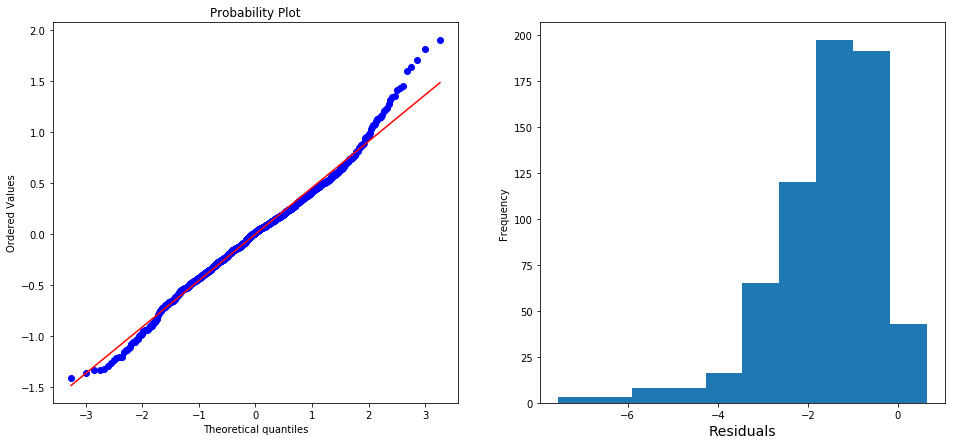

In [20]:
m4 = smf.ols('np.log(wage) ~ exper + np.power(exper,2) + union + goodhlth + black + female +'\
                            'married + service + educ + belowavg + aboveavg', data=data)
fitted = m4.fit(cov_type='HC1')
print(fitted.summary())

plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

### Удаляем незначимые признаки

В предыдущей модели незначимы: цвет кожи, здоровье, семейное положение. Удалим их. Индикатор привлекательности выше среднего тоже незначим, но удалять его не будем, потому что это одна из переменных, по которым на нужно в конце ответить на вопрос.

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     121.1
Date:                Wed, 03 Jul 2019   Prob (F-statistic):          6.49e-150
Time:                        19:35:34   Log-Likelihood:                -799.30
No. Observations:                1259   AIC:                             1617.
Df Residuals:                    1250   BIC:                             1663.
Df Model:                           8                                         
Covariance Type:                  HC1                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3906      0

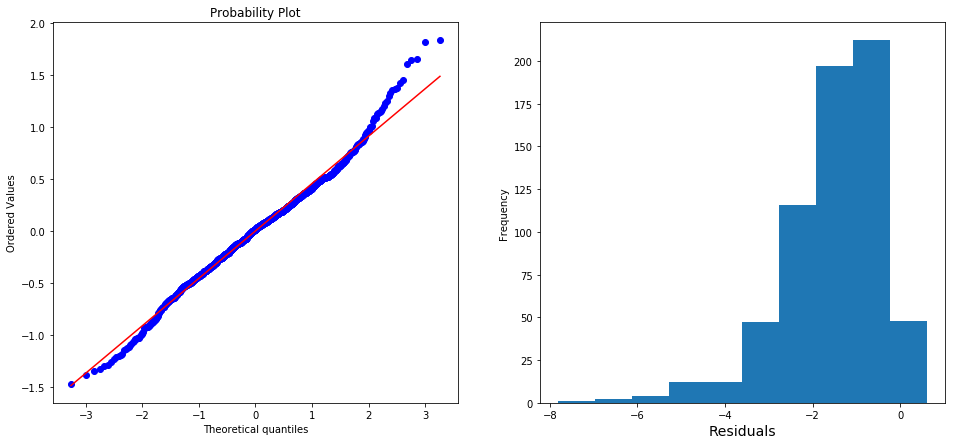

In [21]:
m5 = smf.ols('np.log(wage) ~ exper + np.power(exper,2) + union + female + service + educ +'\
                            'belowavg + aboveavg', data=data)
fitted = m5.fit(cov_type='HC1')
print(fitted.summary())

plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

Посмотрим, не стала ли модель от удаления трёх признаков значимо хуже, с помощью критерия Фишера:

In [22]:
print("F=%f, p=%f, k1=%f" % m4.fit().compare_f_test(m5.fit()))

F=1.611478, p=0.184911, k1=3.000000


Не стала.

Проверим, нет ли наблюдений, которые слишком сильно влияют на регрессионное уравнение:

<Figure size 576x504 with 0 Axes>

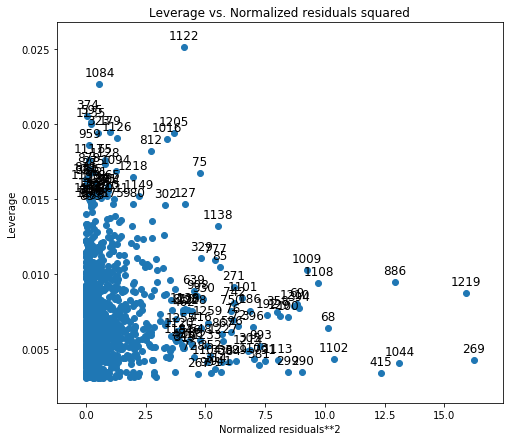

In [23]:
plt.figure(figsize(8,7))
plot_leverage_resid2(fitted)
pylab.show()

In [24]:
data.loc[[1122]]

,wage,exper,union,goodhlth,black,female,married,service,educ,belowavg,aboveavg
1122,6.25,47,0,0,1,1,1,0,5,0,1


In [25]:
data.loc[[269]]

,wage,exper,union,goodhlth,black,female,married,service,educ,belowavg,aboveavg
269,41.67,16,0,0,0,0,1,0,13,0,1


## Выводы

Итоговая модель объясняет 40% вариации логарифма отклика. 

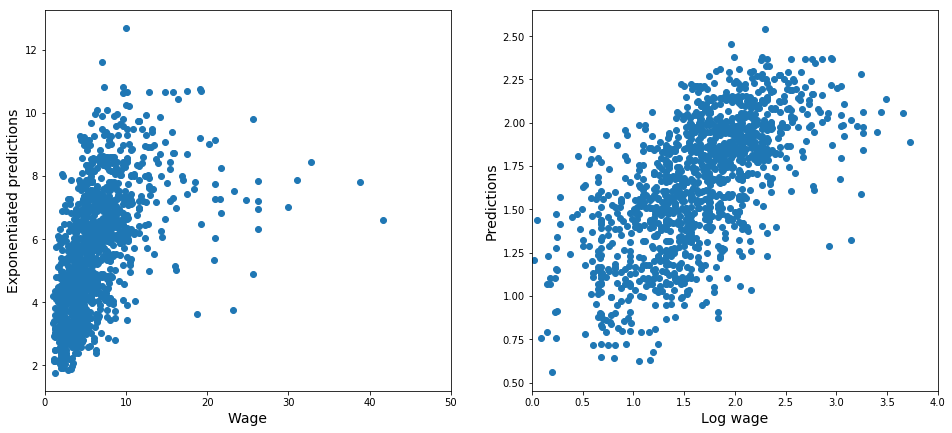

In [26]:
plt.figure(figsize(16,7))
plt.subplot(121)
scatter(data['wage'],np.exp(fitted.fittedvalues))
plt.xlabel('Wage', fontsize=14)
plt.ylabel('Exponentiated predictions', fontsize=14)
plt.xlim([0,50])

plt.subplot(122)
scatter(np.log(data['wage']),fitted.fittedvalues)
plt.xlabel('Log wage', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xlim([0,4])
pylab.show()

При интересующих нас факторах привлекательности стоят коэффициенты -0.1307 (ниже среднего) и -0.0010 (выше среднего). 

Поскольку регрессия делалась на логарифм отклика, интерпретировать их можно как прирост в процентах. С учётом дополнительных факторов представители генеральной совокупности, из которой взята выборка, получают в среднем:

* на 13% меньше, если их привлекательность ниже среднего (p=0.001, 95% доверительный интервал — [5,21]%);
* столько же, если их привлекательность выше среднего (p=0.972, 95% доверительный интервал — [-6,6]%).